In [23]:
import open3d as o3d
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imshowpair
import copy
from PIL import Image
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 15]

In [2]:
import jupyternotify

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.greedy = True

ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
%autonotify -a 120

<IPython.core.display.Javascript object>

In [8]:
rgb_path = '/home/farshad/Documents/Cotton Imaging/18_9_top_RTabMap_Images/18_9_top_rgb/1614054070.802299.jpg'
depth_path = '/home/farshad/Documents/Cotton Imaging/18_9_top_RTabMap_Images/18_9_top_depth/1614054070.802299.png'
rgb_image = plt.imread(rgb_path)
depth_image = plt.imread(depth_path)

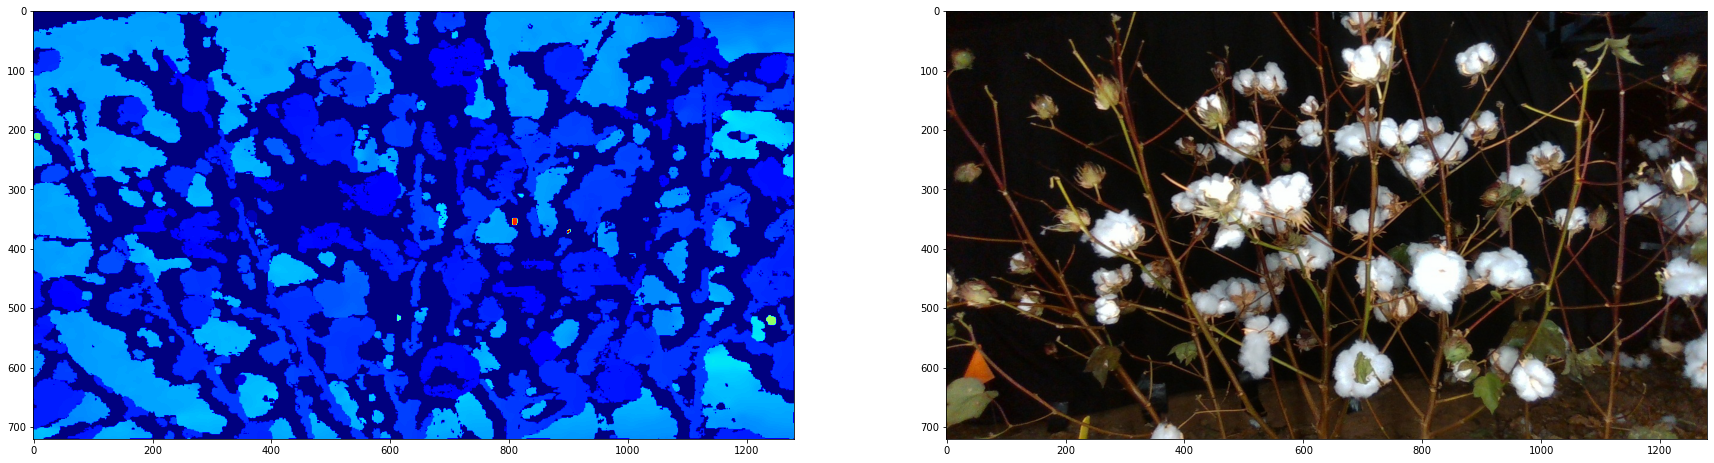

In [16]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(depth_image, cmap = 'jet')
axs[1].imshow(rgb_image)
#fig.colorbar(pos, ax =axs[0], shrink = 0.35)

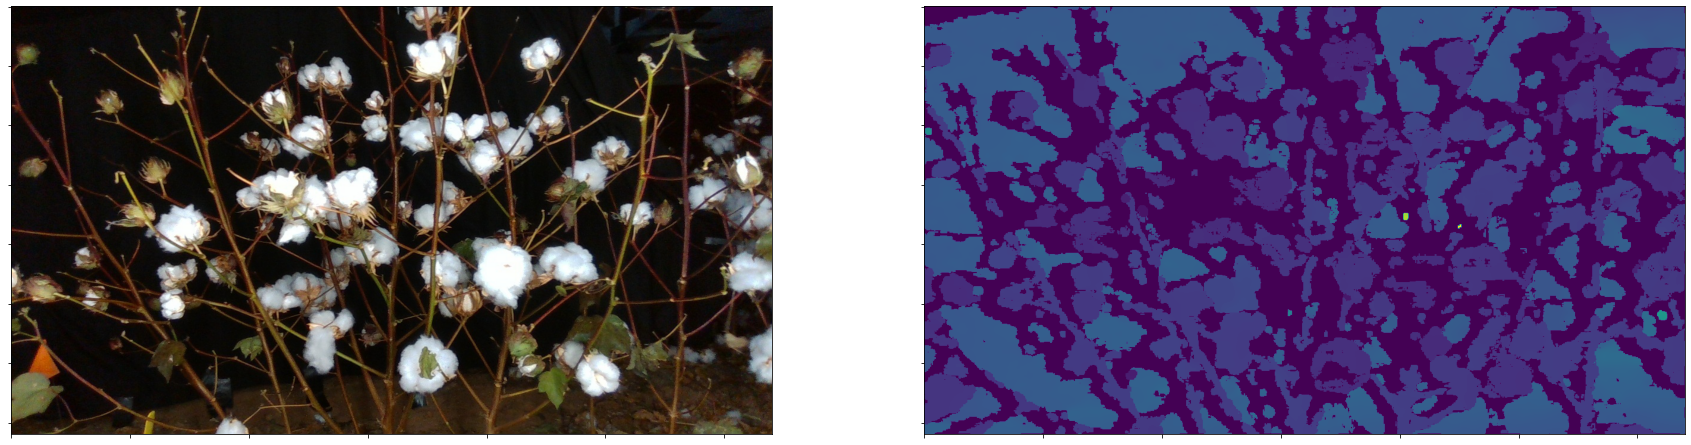

In [20]:
rgb_image_cv = cv2.imread(rgb_path)
depth_image_cv = cv2.imread(depth_path)
imshowpair.imshowpair(rgb_image, depth_image)

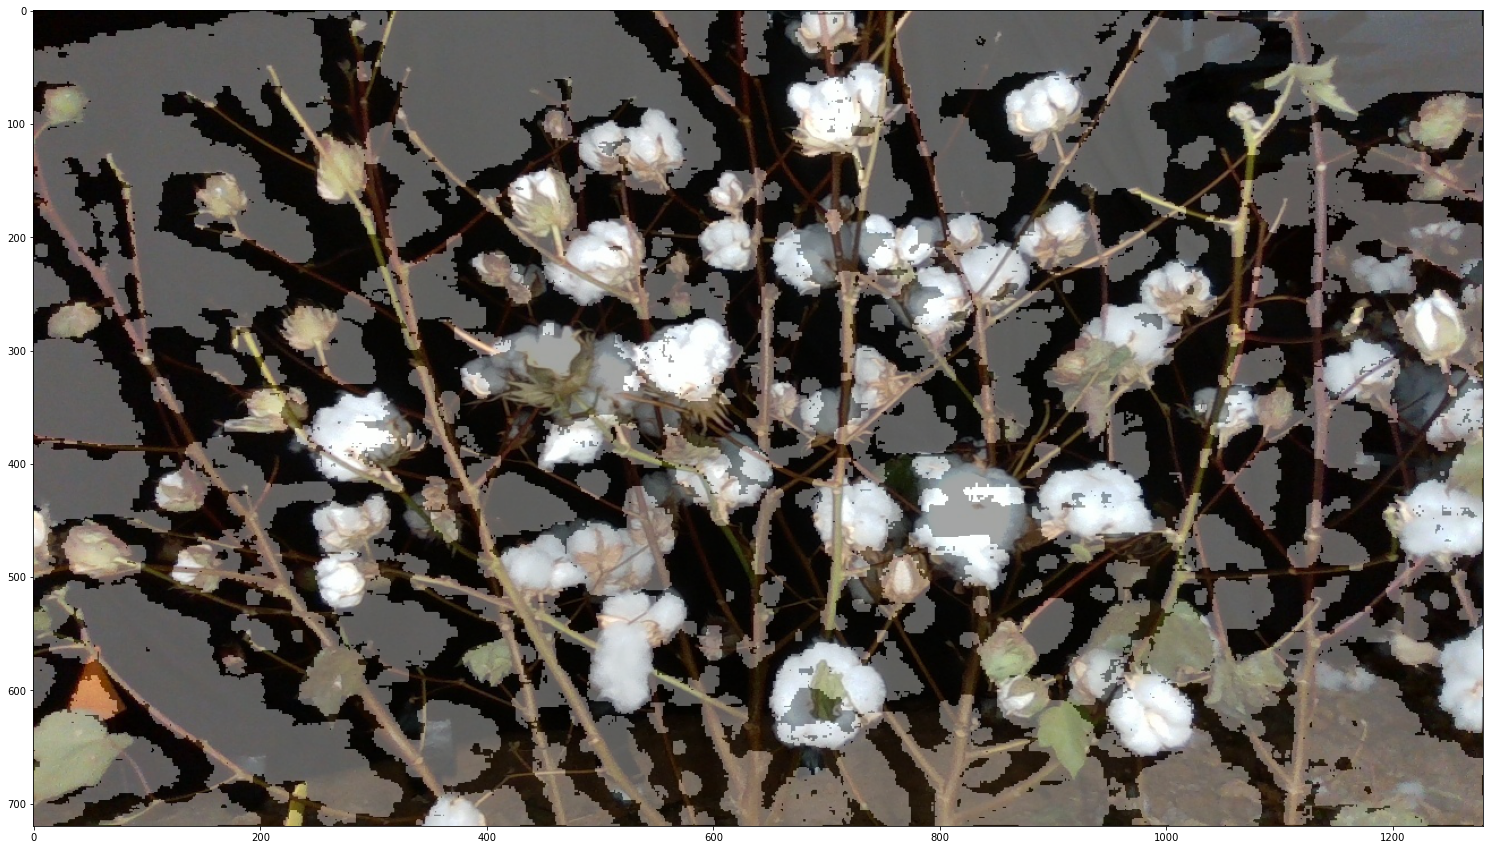

In [37]:
background = Image.open(depth_path)
overlay = Image.open(rgb_path)

background = background.convert("RGBA")
overlay = overlay.convert("RGBA")

new_img = Image.blend(background, overlay, 0.65)
plt.imshow(new_img)

# PointCloud Generation from RGBD image

In [5]:
color_raw = o3d.io.read_image(rgb_path)
depth_raw = o3d.io.read_image(depth_path)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw, convert_rgb_to_intensity=False)
print(rgbd_image)

RGBDImage of size 
Color image : 1280x720, with 3 channels.
Depth image : 1280x720, with 1 channels.
Use numpy.asarray to access buffer data.


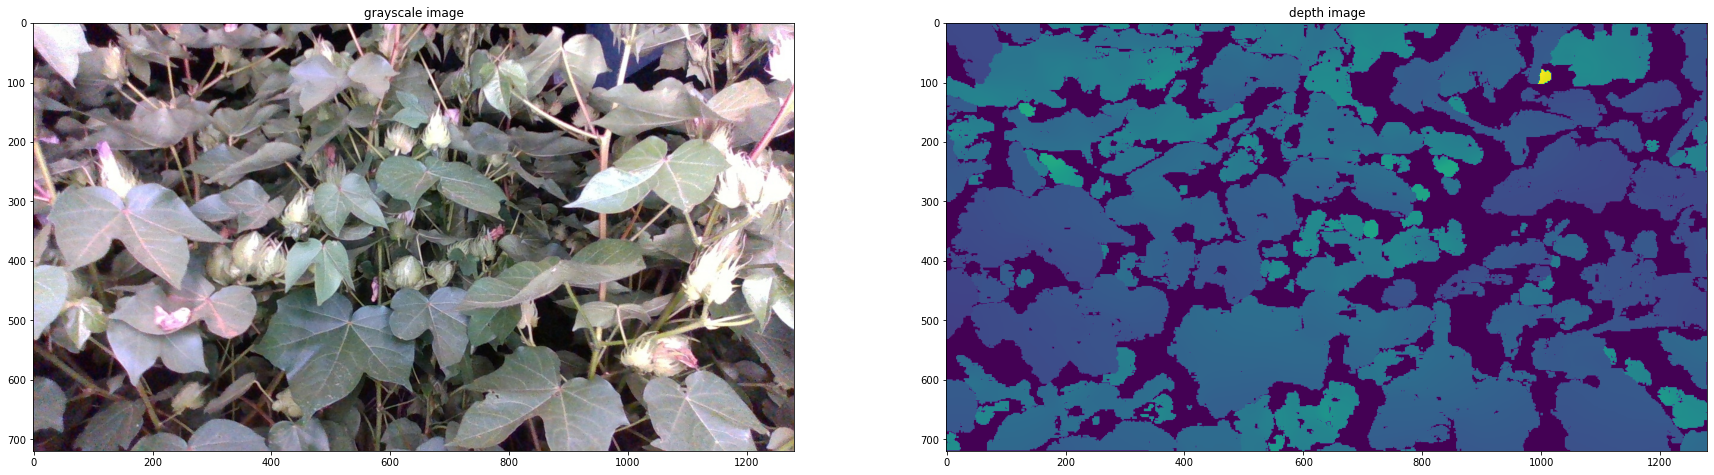

In [6]:
plt.subplot(1, 2, 1)
plt.title('grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [7]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image, 
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))

# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
o3d.visualization.ViewControl.set_zoom(vis.get_view_control(), 0.8)
vis.run()

# RGB images feature detection using GFTT

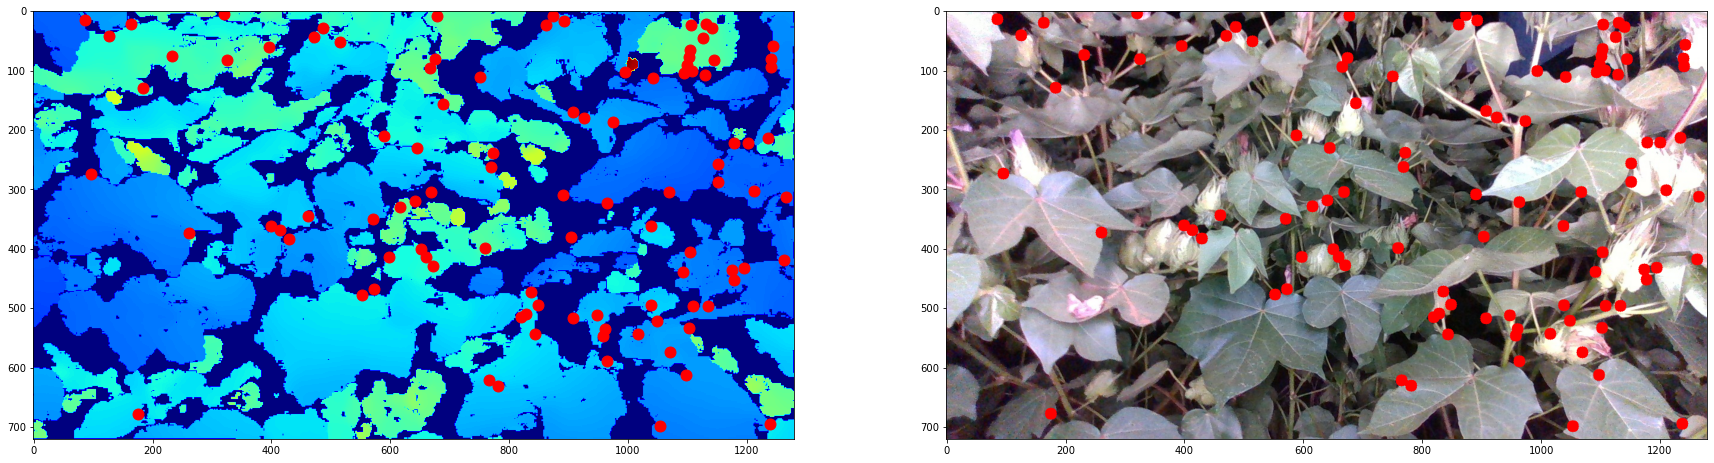

In [8]:
gray = cv2.cvtColor(rgb_image_cv, cv2.COLOR_RGB2GRAY)
corners = cv2.goodFeaturesToTrack(gray, 100, qualityLevel = 0.001, minDistance = 7, blockSize= 3, useHarrisDetector =False, k = 0.04)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(rgb_image,(x,y),10,255,-1)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(depth_image, cmap = 'jet')
axs[1].imshow(rgb_image)

axs[0].scatter(corners[:, 0, 0], corners[:, 0, 1], c='red', s = 120)

# Point Cloud alignment using colored Point Cloud Registration 

In [9]:
rgb_path_2 = '84.jpg'
depth_path_2 = '84.png'

def draw_registration_result_original_color(source, target, transformation):
    source_temp = copy.deepcopy(source)
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target],
                                      zoom=0.5,
                                      front=[-0.2458, -0.8088, 0.5342],
                                      lookat=[1.7745, 2.2305, 0.9787],
                                      up=[0.3109, -0.5878, -0.7468])

In [10]:
color_raw_2 = o3d.io.read_image(rgb_path_2)
depth_raw_2 = o3d.io.read_image(depth_path_2)
rgbd_image_2 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw, convert_rgb_to_intensity=False)
print(rgbd_image)

RGBDImage of size 
Color image : 1280x720, with 3 channels.
Depth image : 1280x720, with 1 channels.
Use numpy.asarray to access buffer data.


In [11]:
pcd_2 = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image_2, 
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))

# Flip it, otherwise the pointcloud will be upside down
pcd_2.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd_2)
o3d.visualization.ViewControl.set_zoom(vis.get_view_control(), 0.8)
vis.run()

In [12]:
source = pcd
target = pcd_2
# draw initial alignment
current_transformation = np.identity(4)
draw_registration_result_original_color(source, target, current_transformation)

In [13]:
# colored pointcloud registration
# This is implementation of following paper
# J. Park, Q.-Y. Zhou, V. Koltun,
# Colored Point Cloud Registration Revisited, ICCV 2017
voxel_radius = [0.04, 0.02, 0.01]
max_iter = [70, 40, 25]
current_transformation = np.identity(4)
print("3. Colored point cloud registration")
for scale in range(3):
    iter = max_iter[scale]
    radius = voxel_radius[scale]
    print([iter, radius, scale])

    print("3-1. Downsample with a voxel size %.2f" % radius)
    source_down = source.voxel_down_sample(radius)
    target_down = target.voxel_down_sample(radius)

    print("3-2. Estimate normal.")
    source_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))
    target_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))

    print("3-3. Applying colored point cloud registration")
    result_icp = o3d.pipelines.registration.registration_colored_icp(
        source_down, target_down, radius, current_transformation,
        o3d.pipelines.registration.TransformationEstimationForColoredICP(),
        o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-6,
                                                          relative_rmse=1e-6,
                                                          max_iteration=iter))
    current_transformation = result_icp.transformation
    print(result_icp)
draw_registration_result_original_color(source, target,
                                        result_icp.transformation)

3. Colored point cloud registration
[70, 0.04, 0]
3-1. Downsample with a voxel size 0.04
3-2. Estimate normal.
3-3. Applying colored point cloud registration
RegistrationResult with fitness=1.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 1760
Access transformation to get result.
[40, 0.02, 1]
3-1. Downsample with a voxel size 0.02
3-2. Estimate normal.
3-3. Applying colored point cloud registration
RegistrationResult with fitness=1.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 5424
Access transformation to get result.
[25, 0.01, 2]
3-1. Downsample with a voxel size 0.01
3-2. Estimate normal.
3-3. Applying colored point cloud registration
RegistrationResult with fitness=1.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 17392
Access transformation to get result.


PointCloud with 638884 points.